In [97]:
import time
import warnings
from IPython.display import display

import catboost as ctb
import lightgbm as lgb
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import xgboost as xgb

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from preprocess.AnovaTestCategoricalFeature import AnovaTest

# Pipeline
from sklearn.pipeline import Pipeline

## zmienne kategoryczne
from sklearn.preprocessing import OrdinalEncoder, RobustScaler, StandardScaler

from preprocess.CustomIterativeImputer import CustomIterativeImputer
from preprocess.BinningFeature import BinningFeature

from preprocess.SelectorNumericalFeature import FeatureSelector
import category_encoders as ce
from preprocess.NeighbourhoodUtil import NeighbourhoodUtil
from preprocess.TransformerNumericalFeature import NumericalFeatureCleaner

np.random.seed(42)
sns.set(font_scale=1.3)
warnings.filterwarnings('ignore')
%matplotlib inline

In [98]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000, "display.precision", 6):
        display(df)

In [101]:
# Path of the file to read. We changed the directory structure to simplify submitting to a competition
home_data_train = 'data/train.csv'
home_data_test = 'data/test.csv'

X_train_dataset = pd.read_csv(home_data_train)
X_test_dataset = pd.read_csv(home_data_test)

In [102]:
X_train_dataset.MSSubClass = X_train_dataset.MSSubClass.astype('category')
X_test_dataset.MSSubClass = X_test_dataset.MSSubClass.astype('category')

X_train_dataset.MSSubClass = X_train_dataset.MSSubClass.cat.add_categories('None')
X_test_dataset.MSSubClass = X_test_dataset.MSSubClass.cat.add_categories('None')

In [103]:
neighbourhood_util = NeighbourhoodUtil()
X_train_dataset['NeighborhoodRegion'] = X_train_dataset['Neighborhood'].apply(neighbourhood_util.get_city_reg)
X_train_dataset.drop(labels=['Neighborhood'], axis=1)
X_test_dataset['NeighborhoodRegion'] = X_test_dataset['Neighborhood'].apply(neighbourhood_util.get_city_reg)
X_test_dataset.drop(labels=['Neighborhood'], axis=1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,NeighborhoodRegion
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,Missing
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,Missing
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,North
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,North
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,North
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,SouthWest
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,SouthWest
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,SouthWest
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,SouthWest


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

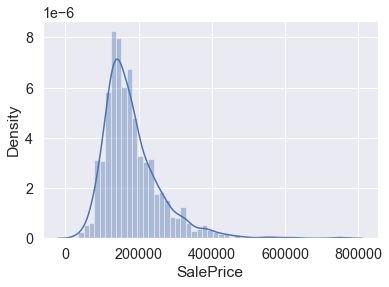

In [104]:
#SalePrice
sns.distplot(X_train_dataset['SalePrice'])

In [105]:
# X_train_dataset['SalePrice'] = np.log(X_train_dataset['SalePrice'])
# sns.distplot(X_train_dataset['SalePrice'])

In [106]:
y = X_train_dataset['SalePrice']
X_train, X_val, y_train, y_val = train_test_split(X_train_dataset.drop(labels=['SalePrice'], axis=1),
                                                  X_train_dataset.SalePrice,
                                                  test_size=0.1,
                                                  random_state=42)

In [107]:
imputer = CustomIterativeImputer()
X_train_impute = imputer.fit_transform(X_train, y_train)
X_val_impute = imputer.fit_transform(X_val, y_val)

In [108]:
numerical_cols = X_train.select_dtypes(include=[np.number]).columns
categorical_cols = X_val.select_dtypes(exclude=[np.number]).columns

In [109]:
binning_cat_feature = BinningFeature(0.92)
X_train_binning_cat_feature = binning_cat_feature.fit_transform(X_train_impute[categorical_cols], y_train)
X_val_binning_cat_feature = binning_cat_feature.fit_transform(X_val_impute[categorical_cols], y_val)

In [110]:
anova_test_train = AnovaTest('SalePrice')
X_train_anova = anova_test_train.fit_transform(X_train_binning_cat_feature[categorical_cols], y_train)
X_val_anova = X_val_binning_cat_feature[X_train_anova.columns]

In [111]:
ordinal_encoder = OrdinalEncoder()
X_train_cat_enc_vals = ordinal_encoder.fit_transform(X_train_anova)
X_val_cat_enc_vals = ordinal_encoder.fit_transform(X_val_anova)

In [112]:
X_train_cat_enc = pd.DataFrame(X_train_cat_enc_vals, columns=X_train_anova.columns, )
X_val_cat_enc = pd.DataFrame(X_val_cat_enc_vals, columns=X_val_anova.columns, )

In [113]:
num_cleaner = NumericalFeatureCleaner(RobustScaler())
X_train_clean = num_cleaner.fit_transform(X_train_impute[numerical_cols], y_train)
X_val_clean = num_cleaner.fit_transform(X_val_impute[numerical_cols], y_val)

In [114]:
estimator = RandomForestRegressor(n_estimators=100, max_depth=10, max_features='auto',
                                  min_samples_leaf=4, min_samples_split=10,
                                  n_jobs=-1, bootstrap=True)

# Define steps
step1 = {'Constant Features': {'frac_constant_values': 0.9}}
step2 = {'Correlated Features': {'correlation_threshold': 0.8}}
step3 = {'Relevant Features': {'estimator': estimator,
                               'verbose': 0,
                               'random_state': 42}}
step4 = {'RFECV Features': {'cv': 5,
                            'estimator': estimator,
                            'step': 1,
                            'scoring': 'neg_mean_squared_error',
                            'verbose': 0}}

# Place steps in a list in the order you want them execute it
steps = [step1, step2]

In [115]:
num_selector = FeatureSelector(steps)
X_train_num_selected = num_selector.fit_transform(X_train_clean[numerical_cols], y_train)

In [116]:
print(f'shape all: {X_train.shape}')
print(f'shape X_train_impute: {X_train_impute.shape}')
print(f'shape_X_train_binning_cat_feature: {X_train_binning_cat_feature.shape}')
print(f'shape X_train_anova : {X_train_anova.shape}')
print(f'shape X_train_enc : {X_train_cat_enc.shape}')
print(f'shape X_train_clean: {X_train_clean.shape}')
print(f'shape X_train_selected: {X_train_num_selected.shape}')

shape all: (1314, 81)
shape X_train_impute: (1314, 81)
shape_X_train_binning_cat_feature: (1314, 45)
shape X_train_anova : (1314, 42)
shape X_train_enc : (1314, 42)
shape X_train_clean: (1314, 36)
shape X_train_selected: (1314, 26)


In [117]:
print(f'shape all: {X_val.shape}')
print(f'shape X_train_impute: {X_val_impute.shape}')
print(f'shape_X_train_binning_cat_feature: {X_val_binning_cat_feature.shape}')
print(f'shape X_train_anova : {X_val_anova.shape}')
print(f'shape X_train_enc : {X_val_cat_enc.shape}')
print(f'shape X_train_clean: {X_val_clean.shape}')

shape all: (146, 81)
shape X_train_impute: (146, 81)
shape_X_train_binning_cat_feature: (146, 45)
shape X_train_anova : (146, 42)
shape X_train_enc : (146, 42)
shape X_train_clean: (146, 36)


In [118]:
result_train_df = pd.concat([X_train_num_selected, X_train_cat_enc], axis=1)
result_val_df = pd.concat([X_val_clean[X_train_num_selected.columns], X_val_cat_enc[X_train_cat_enc.columns]], axis=1)

In [119]:
print(f'shape result_train_df : {result_train_df.shape}')
print(f'shape result_val_df: {result_val_df.shape}')

shape result_train_df : (1314, 68)
shape result_val_df: (146, 68)


In [120]:
from sklearn.metrics import mean_absolute_error

regression_model = LinearRegression()
regression_model.fit(result_train_df, y_train)
y_predicted = regression_model.predict(result_val_df)

mae = mean_absolute_error(y_val, y_predicted)

print('Mean absolute error: ', mae)

Mean absolute error:  65964.28424948423


In [121]:
numerical_pipe = Pipeline(steps=[
    ('num_trans', NumericalFeatureCleaner(RobustScaler())),
    ('num_selector', FeatureSelector(steps))
])

categorical_pipe = Pipeline(steps=[
    ('cat_binning', BinningFeature()),
    ('cat_selector', AnovaTest('SalePrice')),
    ('cat_trans', ce.one_hot.OneHotEncoder(drop_invariant=True))
])

In [122]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_pipe, numerical_cols),
        ('categorical', categorical_pipe, categorical_cols)
    ])

In [123]:
from sklearn.preprocessing import MaxAbsScaler

scalers = [StandardScaler(), RobustScaler(), MaxAbsScaler()]
cat_transformers = [
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
    ce.backward_difference.BackwardDifferenceEncoder(),
    ce.one_hot.OneHotEncoder(drop_invariant=True)
]
regressors = [
    xgb.XGBRegressor(verbosity=1),
    lgb.LGBMRegressor(verbose=0, ),
    ctb.CatBoostRegressor(verbose=0, logging_level='Info')
]

In [124]:
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor())
])

In [125]:
X_train, X_val, y_train, y_val = train_test_split(X_train_dataset.drop(labels=['SalePrice'], axis=1),
                                                  X_train_dataset.SalePrice,
                                                  test_size=0.1,
                                                  random_state=42)


In [126]:
models_df = pd.DataFrame()
pipe_params = {
    'preprocessor__numerical__num_trans__scaler': scalers,
    'preprocessor__categorical__cat_trans': cat_transformers
}

grid = GridSearchCV(pipe, pipe_params, cv=5, verbose=0)
grid_est = grid.fit(X_train, y_train)

In [127]:
print('Training set score: ' + str(grid.score(X_train, y_train)))
print('Test set score: ' + str(grid.score(X_val, y_val)))

# "# model evaluation\n",
# "mse = mean_squared_error(y_val, y_predicted)\n",
# "mae = mean_absolute_error(y_val, y_predicted)\n",
# "rmse = np.sqrt(mean_squared_error(y_val, y_predicted))\n",
# "# msle = mean_squared_log_error(y_val, y_predicted)\n",

# print('Test set score: ' + np.sqrt(mean_squared_error(y_val, y_predicted)))

# Access the best set of parameters
best_params = grid.best_params_
print(f'best_params: {best_params}')
# Stores the optimum model in best_pipe
best_pipe = grid.best_estimator_
print(f'best_pipe: {best_pipe}')

Training set score: 0.9998785904929235
Test set score: 0.8999719540235254
best_params: {'preprocessor__categorical__cat_trans': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__numerical__num_trans__scaler': RobustScaler()}
best_pipe: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('num_trans',
                                                                   NumericalFeatureCleaner(scaler=RobustScaler())),
                                                                  ('num_selector',
                                                                   FeatureSelector(steps=[{'Constant Features': {'frac_constant_values': 0.9}},
                                                                                          {'Correlated Features': {'correlation_threshold': 0.8}}]))]),
                                                  Index(['

In [ ]:
from model.HyperOptimization import HyperOptimization

obj = HyperOptimization(X_train, X_val, y_train, y_val)
opt = obj.process(best_pipe_params=best_params, max_evals=1000)

 66%|██████▋   | 665/1000 [08:13<04:24,  1.27trial/s, best loss: 15379.02910958904] 

In [ ]:
def unpack(x):
    if x:
        return x[0]
    return np.nan

trials_df = pd.DataFrame([pd.Series(t["misc"]["vals"]).apply(unpack) for t in opt[1].trials])
trials_df["loss"] = [t["result"]["loss"] for t in opt[1].trials]
trials_df["trial_number"] = trials_df.index
trials_df['model_choice'] = trials_df['model_choice'].apply(
    lambda x: 'lgbm_regressor' if x == 1 else 'xgb_regressor'
)

In [ ]:
def add_hover_data(fig, df, model_choice):
    # Filter to only columns that are relevant to the current model choice. Note that this relies on
    # the convention of including the model name in the hyperparameter name when we declare the
    # search space.
    cols = [col for col in df.columns if model_choice in col]
    fig.update_traces(
        # This specifies the data that we want to plot for the current model choice.
        customdata=df.loc[df['model_choice'] == model_choice, cols + ['model_choice']],
        hovertemplate="<br>".join(
            [
                f"{col.split('__')[1]}: %{{customdata[{i}]}}"
                for i, col in enumerate(cols)
            ]
        ),
        # We only apply the hover data for the current model choice.
        selector={"name": model_choice},
    )
    return fig

fig = px.scatter(trials_df, x="trial_number", y="loss", color='model_choice')
fig = add_hover_data(fig, trials_df, 'lgbmregressor')
fig = add_hover_data(fig, trials_df, 'xgbregressor')

fig

In [ ]:
def view_contour_plot(trials_df, z, x, y):
    # plotly express does not support contour plots so we will use `graph_objects` instead. `go.Contour
    # automatically interpolates "z" values for our loss.
    fig = go.Figure(
        data=go.Contour(
            z=trials_df.loc[:, z],
            x=trials_df.loc[:, x],
            y=trials_df.loc[:, y],
            contours=dict(
                showlabels=True,  # show labels on contours
                labelfont=dict(size=12, color="white", ),  # label font properties
            ),
            colorbar=dict(title="loss", titleside="right", ),
            hovertemplate="loss: %{z}<br>{x}: %{x}<br>{y}: %{y}<extra></extra>",
        )
    )

    fig.update_layout(
        xaxis_title=f"{x}",
        yaxis_title=f"{y}",
        title={
            "text": f"{x} vs. {y}",
            "xanchor": "center",
            "yanchor": "top",
            "x": 0.5,
        },
    )
    fig.show()

In [ ]:
view_contour_plot(trials_df, 'loss', 'lgbmregressor__learning_rate', 'lgbmregressor__n_estimator')

In [ ]:
view_contour_plot(trials_df, 'loss', 'xgbregressor__learning_rate', 'xgbregressor__n_estimator')

In [ ]:
trials_df[['model_choice', 'loss']].groupby('model_choice').aggregate({
    'loss': ['mean', 'std', 'min', 'max']
}).reset_index().sort_values(('loss', 'mean'), ascending=False)

In [ ]:
best_params = trials_df.loc[trials_df['model_choice'] == 'xgb_regressor'].sort_values('loss', ascending=True).dropna(axis=1).head(1)
best_params

In [ ]:
best_params_dict = best_params.to_dict('records')[0]

del best_params_dict['loss']
del best_params_dict['trial_number']
del best_params_dict['model_choice']
# best_params_dict.update({'max_depth': 6, 'Luna': 9})

best_params_dict

In [ ]:
xgb_regressor = xgb.XGBRegressor(learning_rate=0.12, max_depth=3, n_estimator=540)
best_pipe.set_params(regressor = xgb_regressor)

In [ ]:
best_pipe.fit(X_train_dataset, y)
y_predicted_test = best_pipe.predict(X_test_dataset)
submission = pd.DataFrame(data={'Id': X_test_dataset.Id, 'SalePrice': y_predicted_test})

In [ ]:
submission

In [ ]:
submission.to_csv('C:/Users/kamil/Documents/Python Scripts/linear-regression-house-price/submission/submission_house_price.csv', index=False)